# Clip Field Shapefile
This notebook aims to clip the original field shapefile, removing the polygons outside our Sentinel-2 raster file.  
Besides, the original field shapefile has some geometric problems (such as self-intersection) and polygons too far away from our RoI, which will be fixed as well in this notebook. 

In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
# 16 Oct 2023: gdal must be imported first, and then rasterio can be imported
from osgeo import gdal
import rasterio as rio

In [2]:
# Set some directories. Here we use absolute directories. 
cwd = 'c:\\Users\\m1865\\Desktop\\Ticino'
cwd_Field = cwd + '\\FieldData'
cwd_ProcessedRaster = cwd + '\\ProcessedData'

In [3]:
# Read the shapefile of the Ticino park
raw_FieldShp = gpd.read_file(cwd_Field + '\\Shapefile\\confini_foreste_finale.shp')
raw_FieldShp.head()

,TIPOLOGIA,SOTTO_TIP,COD_AREA,objectid,inspire_id,cod_euap,cod_legge,dentro,nome,nome_breve,...,perim_loca,url1,url2,codice,url3,url4,tipo_geome,schema,note,geometry
0,Vegetazione forestale dei ripiani terrazzati,Boschi e boscaglie dei piani terrazzati domina...,P1,0,None,None,None,0,None,None,...,0.0,None,None,0,None,None,None,None,None,"POLYGON ((478616.680 5063390.365, 478641.900 5..."
1,Vegetazione forestale dei ripiani terrazzati,Boschi e boscaglie dei piani terrazzati domina...,P1,0,None,None,None,0,None,None,...,0.0,None,None,0,None,None,None,None,None,"POLYGON ((478437.612 5063118.869, 478437.810 5..."
2,Vegetazione forestale dei ripiani terrazzati,Boschi e boscaglie dei piani terrazzati domina...,P1,0,None,None,None,0,None,None,...,0.0,None,None,0,None,None,None,None,None,"POLYGON ((478735.017 5063559.917, 478752.477 5..."
3,None,None,A,0,None,None,None,0,None,None,...,0.0,None,None,0,None,None,None,None,None,"POLYGON ((470860.850 5065300.577, 470915.472 5..."
4,None,None,c,0,None,None,None,0,None,None,...,0.0,None,None,0,None,None,None,None,None,None


In [5]:
# Check the CRS of the shapefile
raw_FieldShp.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

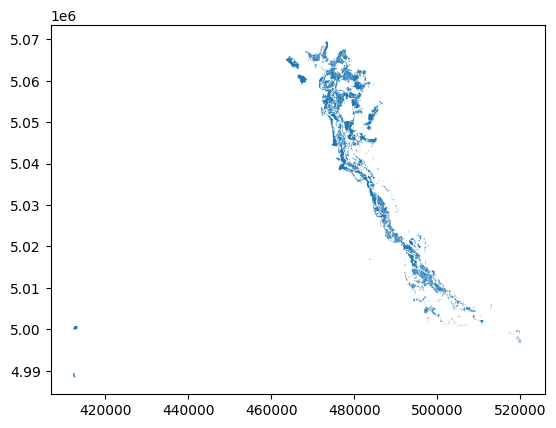

In [6]:
# Plot the shapefile
raw_FieldShp.plot()

In [7]:
# Open our raster file, which is already produced by utilizing R package "preprocS2"
raw_Raster = rio.open(cwd_ProcessedRaster + '\\2022 06')

In [9]:
# Check the CRS of the raster file
raw_Raster.crs

CRS.from_epsg(32632)

In [9]:
# Get the bbox of the raster file: [left,bottom,right,top]
print(raw_Raster.bounds)
raw_Raster_Left = raw_Raster.bounds[0]
raw_Raster_Bottom = raw_Raster.bounds[1]
raw_Raster_Right = raw_Raster.bounds[2]
raw_Raster_Top = raw_Raster.bounds[3]

BoundingBox(left=399960.0, bottom=4990200.0, right=509760.0, top=5100000.0)


In [10]:
# Create a polygon based on the raster extent, no spatial information yet
raw_Raster_Polygon = box(raw_Raster_Left,raw_Raster_Bottom,raw_Raster_Right,raw_Raster_Top)
print(raw_Raster_Polygon)

POLYGON ((509760 4990200, 509760 5100000, 399960 5100000, 399960 4990200, 509760 4990200))


In [11]:
# Convert the polygon to a shapefile polygon which covers our RoI
raw_Raster_ExtentShape = gpd.GeoDataFrame(
    [1],
    geometry=[raw_Raster_Polygon], # Don't forget the [] which makes our polygon into a list
    crs='EPSG:32632'
)
raw_Raster_ExtentShape

,0,geometry
0,1,"POLYGON ((509760.000 4990200.000, 509760.000 5..."


Polygon         1297
MultiPolygon      66
Name: count, dtype: int64

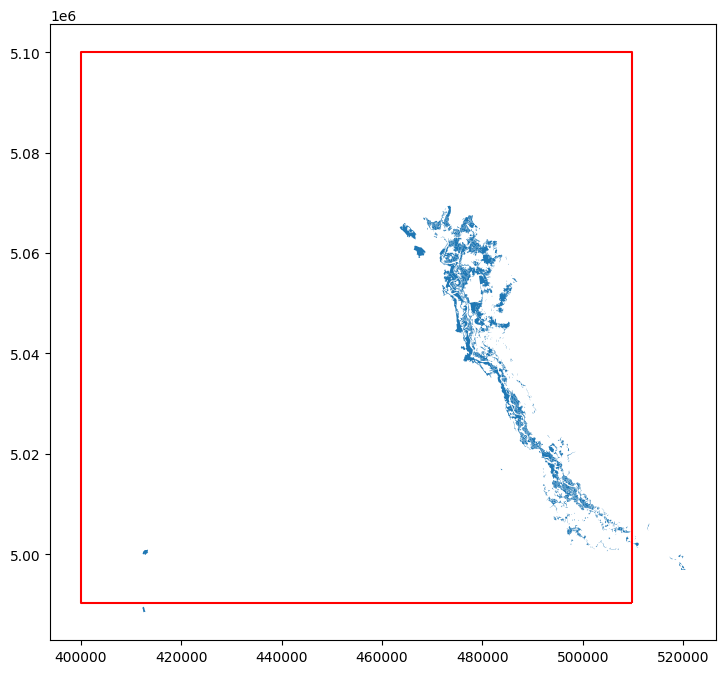

In [12]:
# Plot both the polygon (its boundary only) and the shapefile
fig, ax1 = plt.subplots(1,figsize=(12,8))
raw_Raster_ExtentShape.boundary.plot(ax=ax1,color='red')
raw_FieldShp.plot(ax=ax1)
raw_FieldShp.geom_type.value_counts()

In [13]:
# Our shapefile has many invalid geometries (self-intersection). Thus we need to make them valid before we use the shapefile. 
# raw_FieldShp.is_valid.value_counts()
print("----There are " + str(raw_FieldShp.is_valid.where(raw_FieldShp.is_valid==False).count()) + " invalid geometries inside our shapefile!----")

----There are 189 invalid geometries inside our shapefile!----


In [14]:
# Clean our shapefile, converting invalid geometries to valid ones. 
raw_FieldShp_Valid = raw_FieldShp.make_valid()
raw_FieldShp_Valid.geom_type.value_counts()

Polygon               1266
MultiPolygon            60
GeometryCollection      35
LineString               2
Name: count, dtype: int64

In [15]:
# Clip our shapefile with the spatial polygon
clip_FieldShp = raw_FieldShp_Valid.clip(raw_Raster_Polygon)
clip_FieldShp.geom_type.value_counts()

Polygon         1282
MultiPolygon      65
LineString         2
Name: count, dtype: int64

<Axes: >

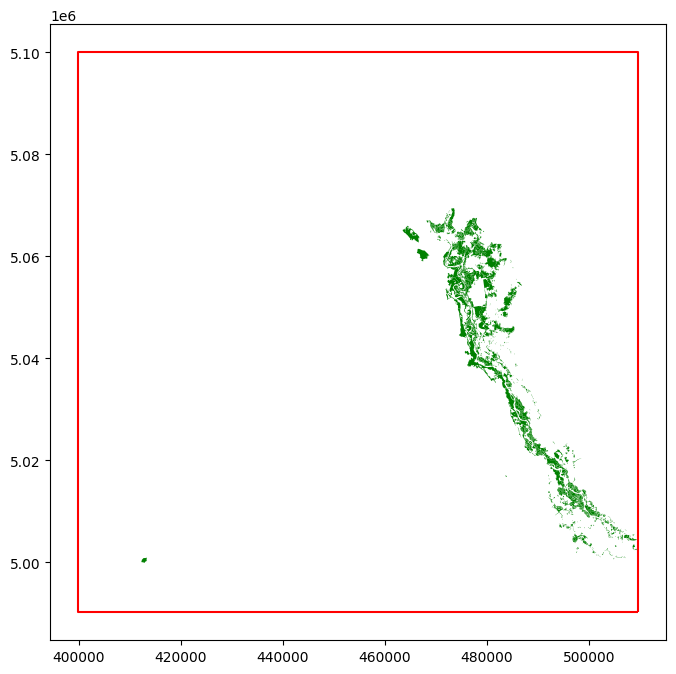

In [16]:
fig, ax1 = plt.subplots(1,figsize=(12,8))
raw_Raster_ExtentShape.boundary.plot(ax=ax1,color='red')
clip_FieldShp.plot(ax=ax1,color='green')

<Axes: >

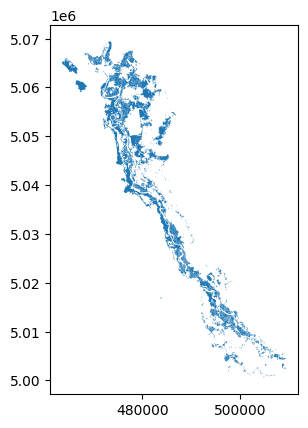

In [17]:
# Now we need to remove the "outlier" part of our shapefile, since it is too far away from our RoI
# Currently we can visually interpret the outlier part, and hence input manually the clip bounding box
clip_FieldShp_Correct = clip_FieldShp.cx[420000:,:]
clip_FieldShp_Correct.plot()

In [18]:
# Check if there is any LineString or Collection inside, which will prevent us from saving this GeoDataFrame into shapefile. 
clip_FieldShp_Correct.geom_type.value_counts()

Polygon         1281
MultiPolygon      65
LineString         2
Name: count, dtype: int64

<Axes: >

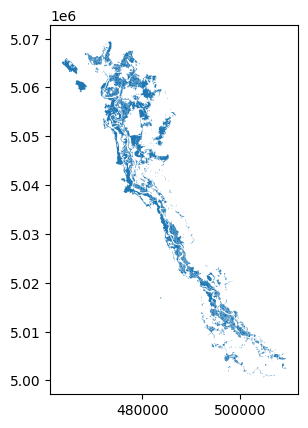

In [19]:
# Remove the incorrect geometries
clip_FieldShp_Correct_DropLineString = clip_FieldShp_Correct[clip_FieldShp_Correct.type != 'LineString']
clip_FieldShp_Correct_DropLineString.plot()

In [20]:
# Save as shapefile into local storage
clip_FieldShp_Correct_DropLineString.to_file(cwd_Field + '\\ShapefileCorretti\\confini_foreste_corretti.shp')

## Original Shapefile Inspection 
This section checks the validity of original shapefile, since it contains some problematic geometries. 

In [29]:
# Read the shapefile created in QGIS
shp_QGIS = gpd.read_file(cwd_Field + '\\ShapefileCorrettiQGIS\\confini_prova.shp').cx[420000:,:]
# Create a new geodataframe with new column "valid"
shp_QGIS_ValidCheck = shp_QGIS.assign(
    valid = shp_QGIS.is_valid
    )

shp_QGIS_ValidCheck.head()

,TIPOLOGIA,SOTTO_TIP,COD_AREA,objectid,inspire_id,cod_euap,cod_legge,dentro,nome,nome_breve,...,url1,url2,codice,url3,url4,tipo_geome,schema,note,geometry,valid
0,Vegetazione forestale dei ripiani terrazzati,Boschi e boscaglie dei piani terrazzati domina...,P1,0,None,None,None,0,None,None,...,None,None,0,None,None,None,None,None,"POLYGON ((478616.680 5063390.365, 478641.900 5...",True
1,Vegetazione forestale dei ripiani terrazzati,Boschi e boscaglie dei piani terrazzati domina...,P1,0,None,None,None,0,None,None,...,None,None,0,None,None,None,None,None,"POLYGON ((478437.612 5063118.869, 478437.810 5...",True
2,Vegetazione forestale dei ripiani terrazzati,Boschi e boscaglie dei piani terrazzati domina...,P1,0,None,None,None,0,None,None,...,None,None,0,None,None,None,None,None,"POLYGON ((478735.017 5063559.917, 478752.477 5...",True
3,None,None,A,0,None,None,None,0,None,None,...,None,None,0,None,None,None,None,None,"POLYGON ((470860.850 5065300.577, 470915.472 5...",True
4,None,None,c,0,None,None,None,0,None,None,...,None,None,0,None,None,None,None,None,"POLYGON ((479662.649 5049895.884, 479810.750 5...",True


In [30]:
# Create another geodataframe which contains the invalid rows
shp_QGIS_InvalidPart = shp_QGIS_ValidCheck[shp_QGIS_ValidCheck.valid == False]
# Get the number of rows
shp_QGIS_InvalidPart.shape[0]

67

In [34]:
# Check the geometric problems in the original field shapefile
from shapely.validation import explain_validity

shp_QGIS_InvalidPart['explaination'] = shp_QGIS_InvalidPart.apply(lambda row: explain_validity(row.geometry),axis=1)
shp_QGIS_InvalidPart['Explaination String'] = shp_QGIS_InvalidPart.apply(lambda row: row.explaination.split('[')[0], axis=1)
shp_QGIS_InvalidPart['Explaination String'].value_counts()

c:\ProgramData\Anaconda3\envs\Ticino\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\ProgramData\Anaconda3\envs\Ticino\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Explaination String
Self-intersection                       54
Ring Self-intersection                  11
Too few points in geometry component     2
Name: count, dtype: int64

## Comparison between the final shapefile creater via Python and that via QGIS (PENDING)

<Axes: >

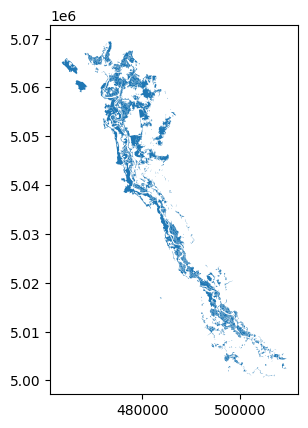

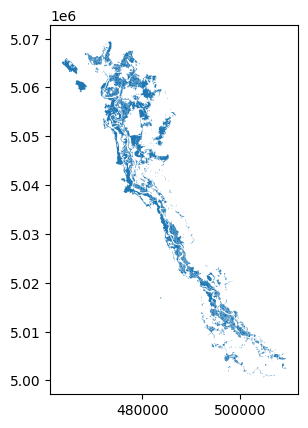

In [21]:
# We also create this clipped shapefile in QGIS, now we try to compare these two results. 
shp_QGIS.plot()
shp_Python = clip_FieldShp_Correct_DropLineString
shp_Python.plot()

In [22]:
shp_QGIS.geom_type.value_counts()

Polygon         1282
MultiPolygon      66
Name: count, dtype: int64

In [23]:
shp_QGIS.is_valid.value_counts()

True     1281
False      67
Name: count, dtype: int64

In [24]:
shp_QGIS.area.sum()

199399866.89059207

In [25]:
shp_Python.area.sum()

201456084.08350927

In [26]:
shp_QGIS.total_bounds

array([ 463513.42039029, 5000597.45028729,  509627.90024949,
       5069411.83409077])

In [27]:
shp_Python.total_bounds

array([ 463513.42039029, 5000597.45028729,  509627.90024949,
       5069411.83409077])

In [28]:
type(shp_QGIS.is_valid)

pandas.core.series.Series